# General

## Mount Google Drive

In [1]:
from google.colab import drive #mount Google Drive
drive.mount('/gdrive')

Mounted at /gdrive


## Imports

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
import os
import sys
import logging
import time
import h5py
import math

import json
import scipy.io.wavfile as wavf
from sklearn.preprocessing import minmax_scale
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm
from PIL import ImageOps
from keras.preprocessing.image import img_to_array,array_to_img

## Set Paths

In [3]:
# set root dir: the path to the github repo folder "XAI_spec_TSC" in your google drive
root_dir = '/gdrive/My Drive/XAI_spec_AudioMNIST/'

paths = {
    'root': root_dir,
    'dataset': os.path.join(root_dir,'AudioMNIST-master'),
    'data': os.path.join(root_dir,'AudioMNIST-master/data'),
    'meta': os.path.join(root_dir,'AudioMNIST-master/data/audioMNIST_meta.txt'),
    'spectrograms': os.path.join(root_dir,'spectrograms'),
    'splits': os.path.join(root_dir,'splits'),
    'results': os.path.join(root_dir, 'results'),
    'models': os.path.join(root_dir, 'results/models'),
    'history': os.path.join(root_dir, 'results/history'),
    'evaluation': os.path.join(root_dir, 'results/evaluation'),
    #'xai': os.path.join(root_dir, 'results/xai'),
    'predictions': os.path.join(root_dir, 'results/predictions'),
    'plots': os.path.join(root_dir, 'results/plots'),
    'plots_waveform': os.path.join(root_dir, 'results/plots/waveform'),
    'plots_spectrograms': os.path.join(root_dir, 'results/plots/spectrograms'),
    'plots_xai': os.path.join(root_dir, 'results/plots/xai'),
    'plots_Grad-CAM': os.path.join(root_dir, 'results/plots/xai/Grad-CAM'),
}

# labels and number of splits
labels = ['gender','digit']
splits = 5

# append the directory to the python path using sys in order to make the seperate py files importable
sys.path.append(root_dir)

## Utils

In [4]:
########## 1. function to write log about the events
def write_log(message):
    logging.basicConfig(level = logging.INFO, filename=os.path.join(root_dir,'events.log'), filemode='a', format='%(asctime)s - %(message)s')
    logging.info(message)
    print(message) 


########## 2. function to create a directory
def create_directory(directory_path):
    if os.path.isdir(directory_path) == False:
        os.mkdir(directory_path)
        write_log('Created folder: '+directory_path)
    #else:
        #writeLog('Folder already exists: '+directory_path)

########## 3. function to calculate time difference between two timepoints from package 'time' and returns the duration in format HH:MM:SS as String
def get_duration(start_time,end_time):
    duration = round(end_time-start_time)
    if duration < 0:
        duration*=-1
    h=math.floor(duration/3600)
    r=duration%3600
    m=math.floor(r/60)
    r=r%60
    s=round(r)
    return(str(h).zfill(2)+':'+str(m).zfill(2)+':'+str(s).zfill(2))

########### 4. function to read spectrograms/labels and return np.arrays ready for training/evaluation/xai methods
def read_spectrograms_hdf5(label,split_index,split_type,resize_factor=1,reshape=False,img_width=227, img_height=227, img_num_channels=1):
  write_log('Started reading '+str(split_type)+' data ...')
  start_time = time.time()
  if label == 'gender':
    label_index = 1
  else:
    label_index = 0
  # read txt with current split paths
  path_to_split_paths = os.path.join(paths['splits'],'AlexNet_'+str(label)+'_'+str(split_index)+'_'+str(split_type)+'.txt')
  text_file = open(path_to_split_paths, 'r')
  split_paths = text_file.read().split('\n')
  text_file.close()
  # if there are empty lines at the end of the txt file there will be an empty list element for each empty line
  # removing empty lines/list elements
  while split_paths[len(split_paths)-1] == '':
    split_paths.pop(len(split_paths)-1)
  # read hdf5 files of the current split and split_type and store it as np.array (spectrograms as x and labels as y)
  index = 0
  x = np.zeros(((len(split_paths),227,227))) # create target array for spectrograms
  y = np.zeros(len(split_paths)) # create target array for labels
  for cur_path in split_paths: # iterate the files
    #read current file
    f = h5py.File(cur_path, 'r')
    x_cur = f['data'][...]
    y_cur = f['label'][...]
    f.close() 
    #extract relevant data of current file
    x_cur = x_cur[0][0]
    y_cur = y_cur[0][label_index]    
    #append current data to x and y
    x[index] = x_cur
    y[index] = y_cur
    # increase index by 1
    index +=1
  x = x/resize_factor
  if reshape:
    x = x.reshape((len(x), img_width, img_height, img_num_channels))
  write_log('Finished reading '+str(split_type)+' data in '+get_duration(start_time,time.time()))
  return x,y

# read txt with current testsplit paths (txt contains paths to spectrograms)
def get_split_paths(path_to_split_paths):
  text_file = open(path_to_split_paths, 'r')
  split_paths = text_file.read().split('\n')
  text_file.close()
  # if there are empty lines at the end of the txt file there will be an empty list element for each empty line
  # removing empty lines/list elements
  while split_paths[len(split_paths)-1] == '':
    split_paths.pop(len(split_paths)-1)
  return split_paths

# function to read a single hdf5 spectrogram
def read_single_spectrogram_hdf5(filepath):
  f = h5py.File(filepath, 'r')
  x = f['data'][...]
  y = f['label'][...]
  f.close()
  return x,y

#create directories for the results
for path in paths:
  if 'result' in paths[path]:
    create_directory(paths[path])

# Waveform and spectrogram plots

In [37]:
# function creates a waveform plot for a single .wav file
# src is the path to the .wav file
# dst is the path were the plot is saved to
# optional the y-axis can be scaled between -1 and 1 (default True)
# optional the plot can be shown (default False)
def create_waveform_plot(src,dst,scale=True,show=False):
  if os.path.isfile(dst):
    if show == True:
      display(Image(filename=dst))
    return False
  create_directory(os.path.join(paths['plots_waveform'],dst.split('/')[-2])) #create the subfolder with participant number, eg. 01
  fs, data = wavf.read(src)
  if scale:
    data = minmax_scale(data,feature_range=(-1,1),axis=0,copy=True) # optional: scales the y-axis between -1 and 1
  duration = len(data)/fs #duration of the file
  time_values = np.arange(0,duration,1/fs) #time vector
  # sometimes time and data dont have the same length which causes an error: fix by adjusting the length
  if len(time_values) != len(data):
    if len(time_values)>len(data):
      time_values = time_values[0:len(data)]
    else:
      data = data[0:len(time_values)]
  plt.plot(time_values,data)
  plt.xlabel('Time [s]')
  plt.ylabel('Amplitude')
  plt.savefig(dst)
  if show:
    plt.show()
  plt.close()
  return True

# function creates a spectrogram plot for a single .hdf5 file - analog to the function for waveform files
def create_spectrogram_plot(cur_spectrogram_data,dst,show=False):
  if os.path.isfile(dst):
    if show == True:
      display(Image(filename=dst))    
    return False
  create_directory(os.path.join(paths['plots_spectrograms'],dst.split('/')[-2])) #create the subfolder with participant number, eg. 01
  # reshape data, create spectrogram image, save as png
  data = cur_spectrogram_data
  data = np.squeeze(data) # alternatively use: data = data[0,0]
  data = data.reshape(227,227,1)
  img = array_to_img(data)
  img = ImageOps.flip(img) # the picture is otherwise upside down
  img.save(dst)
  if show:
    display(img)
  return True

# Grad-CAM
The Code was reimplemented from the following source:
https://keras.io/examples/vision/grad_cam/

## Functions to create a single heatmap

In [6]:
# Note: the following function is from https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
# Note: the following function is from https://keras.io/examples/vision/grad_cam/
def save_and_display_gradcam(img, heatmap, dst, alpha=0.4, show=False):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img = ImageOps.flip(superimposed_img) # the picture is otherwise upside down
    # Save the superimposed image
    superimposed_img.save(dst)
    # Display Grad CAM
    if show:
      display(superimposed_img)

## Prepare spectrograms and call Grad-CAM functions

In [35]:
# function transforms data into the correct shape and calls the Grad-CAM functions above
def create_single_grad_cam(spectrogram_data,dst,model,show=False):
  if os.path.isfile(dst):
    if show == True:
      display(Image(filename=dst))
    return False
  # TODO mkdirs from dst
  create_directory(os.path.join(paths['plots_Grad-CAM'],dst.split('/')[-3])) #create the subfolder with label and split (one is needed for each model), eg. label_gender_split_1
  create_directory(os.path.join(paths['plots_Grad-CAM'],dst.split('/')[-3],dst.split('/')[-2])) #create the subfolder with participant number, eg. 01
  # reshape image to grayscale
  img = spectrogram_data.reshape(227,227,1)
  # reshape data for model
  x_cur = spectrogram_data/255
  x_cur = x_cur.reshape(1,227,227,1)
  # define last convolutional layer
  last_conv_layer_name = 'conv2d_4'
  # Remove last layer's softmax
  model.layers[-1].activation = None
  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(x_cur, model, last_conv_layer_name)
  # Merge heatmap with original image and save result
  save_and_display_gradcam(img, heatmap,dst,show=show)
  return True

# LRP

In [ ]:
# TODO

# LIME

In [ ]:
# TODO

# Input handlers

## For several spectrograms

In [8]:
def check_inputs(selected_outputs,selected_labels,selected_splits,selected_mode,selected_nb_examples,selected_scale,selected_show):
  # set valid inputs
  valid_outputs = ['waveform','spectrograms','Grad-CAM']
  valid_labels = ['gender','digit']
  valid_splits = [0,1,2,3,4]
  valid_mode = ['examples','all','single']
  valid_nb_examples = list(range(1, 6)) # second value is not valid, example: range(1,3) --> [1,2]
  valid_scale = [False,True]
  valid_show = [False,True]
  # check validity of the selected inputs
  for selected_output in selected_outputs:
    if selected_output not in valid_outputs:
      write_log('Interrupted due to incorrect input parameters in selected outputs!')
      return False
  for selected_label in selected_labels:
    if selected_label not in valid_labels:
      write_log('Interrupted due to incorrect input parameters in selected labels!')
      return False
  for selected_split in selected_splits:
    if selected_split not in valid_splits:
      write_log('Interrupted due to incorrect input parameters in selected splits!')
      return False
  if selected_splits == [4] and selected_labels == ['gender']:
    write_log('Interrupted due to incorrect input parameters: Model gender 4 does not exist!')
    return False
  if selected_mode[0] not in valid_mode or len(selected_mode)>1:
    write_log('Interrupted due to incorrect input parameters in selected mode!')
    return False
  if selected_nb_examples not in valid_nb_examples:
    write_log('Interrupted due to incorrect input parameters in selected nb examples!')
    return False
  if selected_scale not in valid_scale:
    write_log('Interrupted due to incorrect input parameters in selected scale!')
    return False
  if selected_show not in valid_show:
    write_log('Interrupted due to incorrect input parameters in selected show!')
    return False

def create_outputs(selected_outputs,selected_labels,selected_splits,selected_mode='single',selected_nb_examples=3,selected_scale=True,selected_show=False):
  write_log('Started creating outputs ...')
  # handle wrong inputs
  valid_inputs = check_inputs(selected_outputs,selected_labels,selected_splits,selected_mode,selected_nb_examples,selected_scale,selected_show)
  if valid_inputs == False:
    return
  # set output types: needed to find correct path from paths variable
  output_types = ['plots_waveform','plots_spectrograms','plots_Grad-CAM']
  # read meta to get gender label later
  metaData = json.load(open(paths['meta']))
  # iterate existing models
  for model_name in os.listdir(paths['models']):
    # load model
    model = load_model(os.path.join(paths['models'],model_name))
    net,label,split_index = model_name.rstrip(".h5").split("/")[-1].split("_")
    write_log('Current Model: '+label+'_'+str(split_index))
    # skip current model, if label or split was not selected
    if label not in selected_labels or int(split_index) not in selected_splits:
      write_log('Model not selected!')
      continue
    # set path to txt file which contains the spectrogram paths of the current test split
    path_to_split_paths = os.path.join(paths['splits'],net+'_'+str(label)+'_'+str(split_index)+'_test'+'.txt')
    # read txt
    split_paths = get_split_paths(path_to_split_paths)
    # set counters for breaks
    file_counter = 0
    example_counter_male = [0,0,0,0,0,0,0,0,0,0]
    example_counter_female = [0,0,0,0,0,0,0,0,0,0]
    # set counters to track how many outputs were generated/existed
    created_counter ={'waveform': 0, 'spectrograms': 0, 'Grad-CAM': 0}
    existed_counter ={'waveform': 0, 'spectrograms': 0, 'Grad-CAM': 0}
    # read predictions of current model
    predictions = pd.read_csv(os.path.join(paths['predictions'],'predictions_'+label+'_'+str(split_index)+'.csv'))
    # iterate files in testsplit  
    for filepath in split_paths:
      # if single mode is selected skip after the first file
      if file_counter >0:
        break
      # infer sample info from name
      net, dig, vp, rep = filepath[:len(filepath)-5].split('/')[-1].split('_') # filepath.rstrip(".hdf5").split("/")[-1].split("_") --> cutting of reperition 5 for example
      # get gender
      # gender = 0 if metaData[vp]["gender"] == "male" else 1 
      gender = metaData[vp]['gender']
      # if example mode is selected skip if nb_examples is reached
      if gender == 'male':
        if example_counter_male[int(dig)] == int(selected_nb_examples): # continue if enough examples are created for the current digit
          continue
      else:
        if example_counter_female[int(dig)] == int(selected_nb_examples): # continue if enough examples are created for the current digit
          continue
      # get prediction of current spectrogram
      cur_prediction = predictions[(predictions['digit'] == int(dig)) & (predictions['participant'] == int(vp)) & (predictions['repetition'] == int(rep))]
      cur_prediction = cur_prediction.iloc[0]['predicted']
      # set saving paths
      dst = {}
      for output_type in output_types: # for XAI methods there are different output plots for each model which makes an additional folder structure necessary
        if output_type in ['plots_waveform','plots_spectrograms']:
          additional_folder = '' # no additional folder for waveform and spectrograms
          additional_prediction = ''
        else:
          additional_folder = 'label_'+str(label)+'_split_'+str(split_index) # additional folder (for each model) for XAI methods
          additional_prediction = '_predicted_'+str(cur_prediction)
        dst[output_type] = os.path.join(paths[output_type],additional_folder,str(vp),str(gender)+'_'+str(dig)+'_'+str(vp)+'_'+str(rep)+additional_prediction+'.png') # set path
      # set waveform source path
      src_waveform = os.path.join(paths['data'],str(vp),str(dig)+'_'+str(vp)+'_'+str(rep)+'.wav')
      # read spectrogram from hdf5 file
      cur_spectrogram_data,_ = read_single_spectrogram_hdf5(filepath)
      # call functions to create outputs
      if 'waveform' in selected_outputs:
        count = create_waveform_plot(src_waveform,dst['plots_waveform'],scale=selected_scale,show=selected_show)
        if count == True: created_counter['waveform'] += 1
        elif count == False: existed_counter['waveform'] +=1
      if 'spectrograms' in selected_outputs:
        count = create_spectrogram_plot(cur_spectrogram_data,dst['plots_spectrograms'],show=selected_show)
        if count == True: created_counter['spectrograms'] += 1
        elif count == False: existed_counter['spectrograms'] +=1        
      if 'Grad-CAM' in selected_outputs:
        count = create_single_grad_cam(cur_spectrogram_data,dst['plots_Grad-CAM'],model,show=selected_show)
        if count == True: created_counter['Grad-CAM'] += 1
        elif count == False: existed_counter['Grad-CAM'] +=1
      if selected_mode == ['single']:
        file_counter +=1
      if selected_mode == ['examples']:
        if gender == 'male':
          example_counter_male[int(dig)] +=1
        else:
          example_counter_female[int(dig)] +=1
    if 'waveform' in selected_outputs:
      write_log('Waveform: created '+str(created_counter['waveform'])+', existed '+str(existed_counter['waveform']))
    if 'spectrograms' in selected_outputs:
      write_log('Spectrograms: created '+str(created_counter['spectrograms'])+', existed '+str(existed_counter['spectrograms']))
    if 'Grad-CAM' in selected_outputs:
      write_log('Grad-CAM: created '+str(created_counter['Grad-CAM'])+', existed '+str(existed_counter['Grad-CAM']))
  write_log('Finished creating outputs!')

## For specific spectrogram/model

In [31]:
def check_inputs_specific(selected_outputs,selected_label,selected_split,selected_digit,selected_participant,selected_repetition,selected_scale,selected_show):
  # set valid inputs
  valid_outputs = ['waveform','spectrograms','Grad-CAM']
  valid_labels = ['gender','digit']
  valid_splits = [0,1,2,3,4]
  valid_digits = list(range(0, 10)) # second value is not valid, example: range(1,3) --> [1,2]
  valid_participants = get_participants_of_testsplit(selected_label,selected_split, show = False) #list(range(1, 61)) # second value is not valid, example: range(1,3) --> [1,2]
  valid_repetitions = list(range(0,50)) # second value is not valid, example: range(1,3) --> [1,2]
  valid_scale = [False,True]
  valid_show = [False,True]
  # check validity of the selected inputs
  for selected_output in selected_outputs:
    if selected_output not in valid_outputs:
      write_log('Interrupted due to incorrect input parameters in selected outputs!')
      return False
  if isinstance(selected_label,str) == False or selected_label not in valid_labels:
    write_log('Interrupted due to incorrect input parameters in selected label!')
    return False
  if isinstance(selected_split,int) == False or selected_split not in valid_splits:
    write_log('Interrupted due to incorrect input parameters in selected split!')
    return False
  if selected_split == 4 and selected_label == 'gender':
    write_log('Interrupted due to incorrect input parameters: Model gender 4 does not exist!')
    return False
  if isinstance(selected_digit,int) == False or selected_digit not in valid_digits:
    write_log('Interrupted due to incorrect input parameters in selected digit!')
    return False
  if isinstance(selected_participant,int) == False or selected_participant not in valid_participants:
    write_log('Interrupted due to incorrect input parameters in selected participant!')
    return False
  if isinstance(selected_repetition,int) == False or selected_repetition not in valid_repetitions:
    write_log('Interrupted due to incorrect input parameters in selected repetition!')
    return False
  if selected_scale not in valid_scale:
    write_log('Interrupted due to incorrect input parameters in selected scale!')
    return False
  if selected_show not in valid_show:
    write_log('Interrupted due to incorrect input parameters in selected show!')
    return False

def create_outputs_specific(selected_outputs,selected_label,selected_split,selected_digit,selected_participant,selected_repetition,selected_scale=True,selected_show=True):
  write_log('Started creating specific outputs ...')
  valid_inputs = check_inputs_specific(selected_outputs,selected_label,selected_split,selected_digit,selected_participant,selected_repetition,selected_scale,selected_show)
  if valid_inputs == False:
    return
  # transform participant and repetition number into correct format
  selected_participant = str(specific_selected_participant).zfill(2)
  specific_selected_repetition = str(selected_repetition).zfill(2)
  # set output types: needed to find correct path from paths variable
  output_types = ['plots_waveform','plots_spectrograms','plots_Grad-CAM']
  # read meta to get gender label later
  metaData = json.load(open(paths['meta'])) 
  # load selected model
  model = load_model(os.path.join(paths['models'],'AlexNet_'+selected_label+'_'+str(selected_split)+'.h5'))
  # read predictions of current model
  predictions = pd.read_csv(os.path.join(paths['predictions'],'predictions_'+selected_label+'_'+str(selected_split)+'.csv'))
  # get prediction of current spectrogram
  cur_prediction = predictions[(predictions['digit'] == int(selected_digit)) & (predictions['participant'] == int(selected_participant)) & (predictions['repetition'] == int(selected_repetition))]
  cur_prediction = cur_prediction.iloc[0]['predicted']
  # get gender
  gender = metaData[str(selected_participant)]['gender']
  # set saving paths
  dst = {}
  for output_type in output_types: # for XAI methods there are different output plots for each model which makes an additional folder structure necessary
    if output_type in ['plots_waveform','plots_spectrograms']:
      additional_folder = '' # no additional folder for waveform and spectrograms
      additional_prediction = ''
    else:
      additional_folder = 'label_'+str(selected_label)+'_split_'+str(selected_split) # additional folder (for each model) for XAI methods
      additional_prediction = '_predicted_'+str(cur_prediction)
    dst[output_type] = os.path.join(paths[output_type],additional_folder,str(selected_participant),str(gender)+'_'+str(selected_digit)+'_'+str(selected_participant)+'_'+str(selected_repetition)+additional_prediction+'.png') # set path
  # set waveform and spectrogram source path
  src_waveform = os.path.join(paths['data'],str(selected_participant),str(selected_digit)+'_'+str(selected_participant)+'_'+str(selected_repetition)+'.wav')
  src_spectrogram = os.path.join(paths['spectrograms'],str(selected_participant),'AlexNet_'+str(selected_digit)+'_'+str(selected_participant)+'_'+str(selected_repetition)+'.hdf5')
  # read spectrogram from hdf5 file
  cur_spectrogram_data,_ = read_single_spectrogram_hdf5(src_spectrogram)
  # call functions to create outputs
  if 'waveform' in selected_outputs:
    count = create_waveform_plot(src_waveform,dst['plots_waveform'],scale=selected_scale,show=selected_show)
    if count == True:
      write_log('Waveform plot created')
    else:
      write_log('Waveform plot already exists')   
  if 'spectrograms' in selected_outputs:
    count = create_spectrogram_plot(cur_spectrogram_data,dst['plots_spectrograms'],show=selected_show)
    if count == True:
      write_log('Spectrogram created')
    else:
      write_log('Spectrogram already exists')      
  if 'Grad-CAM' in selected_outputs:
    count = create_single_grad_cam(cur_spectrogram_data,dst['plots_Grad-CAM'],model,show=selected_show)
    if count == True:
      write_log('Grad-CAM created')
    else:
      write_log('Grad-CAM already exists')   
  write_log('Finished creating specific outputs!')

# Set outputs and run script

## Set inputs for several spectrograms

In [ ]:
selected_outputs = ['waveform','spectrograms','Grad-CAM'] # options: 'waveform','spectrograms','Grad-CAM', Note: don't use single strings, example: 'waveform' --> won't work, ['waveform'] --> works
selected_labels = ['digit','gender'] # options: 'gender', 'digit', see Note for selected_outputs
selected_splits = [0,1,2,3,4] # options: 0-4, see Note for selected_outputs
selected_mode = ['examples'] # options: 'examples' 'all' 'single' (default: 'examples'), see Note for selected_outputs
selected_nb_examples = 1 # number of examples for each digit of each participant (Allowed range: 1-5, default: 3)
selected_scale = True # only for waveform plots: optionally the y-axis can be scaled between -1 and 1 (default: True)
selected_show = False # optionally the plot can be shown (default: False)

## Run script for several spectrograms

In [ ]:
create_outputs(selected_outputs,
               selected_labels,
               selected_splits,
               selected_mode,
               selected_nb_examples,
               selected_scale,
               selected_show)

## Set inputs for a specific spectrogram/model

In [17]:
specific_selected_outputs = ['waveform','spectrograms','Grad-CAM'] # Note: don't use single strings, example: 'waveform' --> won't work, ['waveform'] --> works
specific_selected_label = 'gender' # options: 'gender' or 'digit'
specific_selected_split = 0 # options: 0-4 (4 only for label digit)
specific_selected_digit = 0 # options: 0-9
specific_selected_participant = 7 # options 1-60
specific_selected_repetition = 0 # options 0-49
specific_selected_scale = True # only for waveform plots: optionally the y-axis can be scaled between -1 and 1 (default: True)
specific_selected_show = True # optionally the plot can be shown (default: True)

## Run script for a specific spectrogram/model

Started creating specific outputs ...


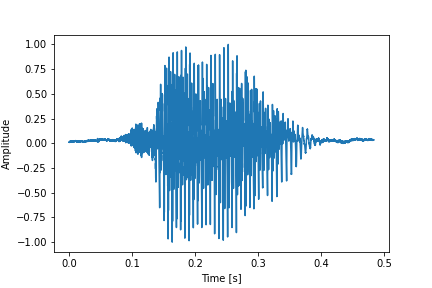

Waveform plot already exists


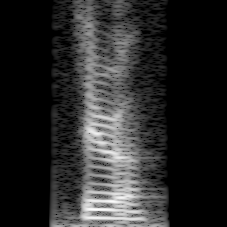

Spectrogram already exists


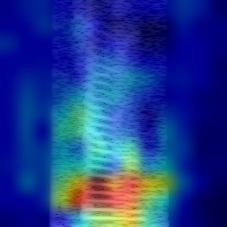

Grad-CAM already exists
Finished creating specific outputs!


In [38]:
create_outputs_specific(specific_selected_outputs,
                        specific_selected_label,
                        specific_selected_split,
                        specific_selected_digit, 
                        specific_selected_participant,
                        specific_selected_repetition, 
                        specific_selected_scale,
                        specific_selected_show)

# Input information
This section helps to determine interesting spectrograms. Afterwards you can move back to the previous section to generate the corresponding explanations of the identified spectrograms.

## Utils for input information

In [15]:
# function reads and returns predictions of a model
def get_predictions(selected_label,selected_split):
  path_to_predictions = os.path.join(paths['predictions'],'predictions_'+selected_label+'_'+str(selected_split)+'.csv')
  predictions = pd.read_csv(path_to_predictions)
  # for row in predictions.itertuples(index=True, name='Pandas'):
  #   print(row.digit, row.participant, row.repetition, row.actual, row.predicted)
  return predictions

# function prints the gender of a specific participant, several or all participants
def get_gender_of_participants(selected_participants=['all']):
  # catch wrong input "int" or "String"
  if isinstance(selected_participants,int) or selected_participants == 'all':
    selected_participants = [selected_participants]
  metaData = json.load(open(paths['meta']))
  # for all participants
  if selected_participants == ['all']:
    for participant in metaData.keys():
      print(participant+': '+metaData[participant]['gender'])
  # for the selected participants
  else:
    for participant in selected_participants:
      participant = str(participant).zfill(2)
      print(participant+': '+metaData[participant]['gender'])

# function returns participants which are in a specific testsplit
def get_participants_of_testsplit(label,split,show=True):
  predictions = get_predictions(label,split)
  participants = predictions['participant'].unique()
  if show == True:
    display(participants)
  return participants

# function returns wrong/correct predicted predictions
def get_wrong_correct_predictions(label,split,mode,limit=None, show=True):
  predictions = get_predictions(label,split)
  if mode == 'wrong':
    filtered_predictions = predictions[(predictions['actual'] != predictions['predicted'])]
  elif mode == 'correct':
    filtered_predictions = predictions[(predictions['actual'] == predictions['predicted'])]
  else:
    print('Check mode (valid options: wrong and correct)!')
  if limit != None and isinstance(limit,int):
    filtered_predictions = filtered_predictions[:limit]
  if show == True:
    pd.set_option('max_rows', 6000)
    display(filtered_predictions)
  return filtered_predictions

## wrongly/correctly predicted spectrograms

In [ ]:
filtered_predictions = get_wrong_correct_predictions('gender',0,mode='wrong',show=True,limit=None)

,digit,participant,repetition,actual,predicted
298,5,2,8,male,female
569,1,36,26,female,male
595,1,36,5,female,male
598,1,36,8,female,male
603,2,36,11,female,male
921,8,36,28,female,male
977,9,36,33,female,male
991,9,36,46,female,male
996,9,36,6,female,male
1505,0,47,13,female,male


## Participants in testsplits

In [16]:
participants_in_testsplit = get_participants_of_testsplit('gender',0,show=True)

array([38,  7, 23, 58, 59, 60])

## Gender of participants

In [ ]:
print_gender([1,4,5,34]) # options: 'all', integer or list of integers

01: male
04: male
05: male
34: male
